In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg import eigh


In [3]:
folder_path = "data/anatomicalSegmentations"


def load_data(folder_path):
	target_size = (64, 64)  # Resize to 64x64
	image_files = ([f for f in os.listdir(folder_path) if f.endswith(".png")])
	image_vectors = []
	for file in image_files:
		img_path = os.path.join(folder_path, file)
		
		img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
		img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
		img_normalized = img_resized.astype(np.float32) / 255.0		
		img_vector = img_normalized.flatten()

		image_vectors.append(img_vector)
	# Convert list to numpy array

	image_matrix = np.array(image_vectors)

	return image_matrix

images = load_data(folder_path)

In [4]:
def save_image(data: np.ndarray, filename):
    """
    Extracts image data from a .mat file, normalizes it, and saves it as a PNG file.

    Parameters:
        data (np.ndarray): input data (expected shape: (channels, height, width))
        filename (str): Name of the file to save the image to.
    """

    data_normalized = (255 * (data - np.min(data)) / (np.max(data) - np.min(data))).astype(np.uint8)

    if data_normalized.shape[0] == 3:
        data_normalized = np.transpose(data_normalized, (1, 2, 0))

    plt.imshow(data_normalized)
    plt.axis("off")
    # plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    

In [5]:
def center_image(images: np.ndarray):
    mean = np.mean(images)
    images = images - mean
    return images

centered_images = center_image(images)

### Part A: Perform PCA

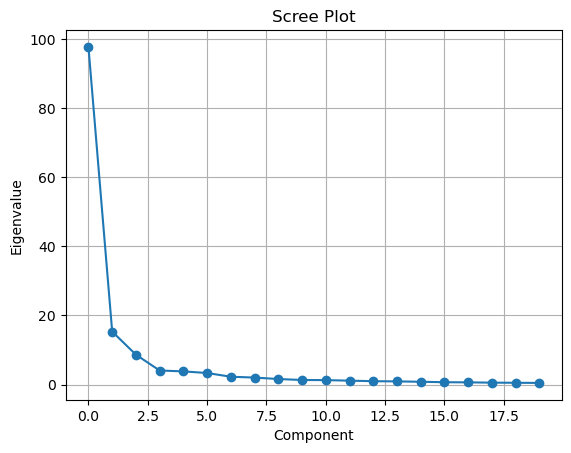

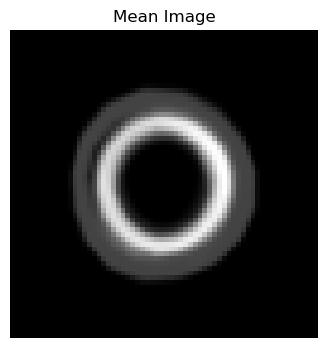

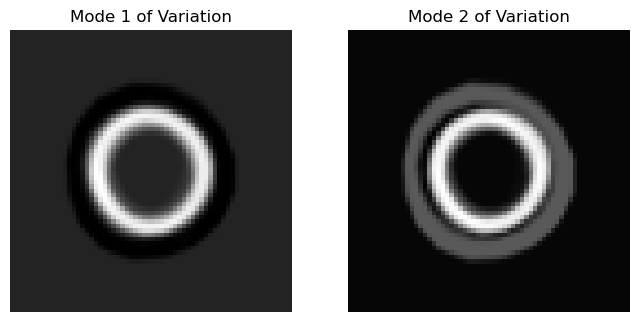

In [125]:

def pca_segmentation(centered_images, n_components=10):
	"""
	Applies PCA to vectorized images, shows eigen spectrum, mean image, and first 2 modes of variation.
	"""
	num_images = centered_images.shape[0]
	mean_image = np.mean(centered_images, axis=0)
	centered = np.reshape(centered_images, (num_images, -1))

	cov = np.cov(centered, rowvar=False)
	eigenvalues, eigenvectors = np.linalg.eigh(cov)
	idx = np.argsort(eigenvalues)[::-1]
	eigenvalues = eigenvalues[idx]
	eigenvectors = eigenvectors[:, idx]

	mode_images = []

	mode_images.append(mean_image + np.sqrt(eigenvalues[0]) * eigenvectors[:, 0])
	mode_images.append(mean_image + np.sqrt(eigenvalues[1]) * eigenvectors[:, 1])

	# Plot Eigen Spectrum
	plt.plot(np.arange(0, 20), eigenvalues[:20], marker='o')
	plt.xlabel("Component")
	plt.ylabel("Eigenvalue")
	plt.title("Scree Plot")
	plt.grid(True)
	plt.show()
	# Plot Mean Image
	plt.figure(figsize=(4, 4))
	plt.imshow(mean_image.reshape(64, 64), cmap='gray')
	plt.title("Mean Image")
	plt.axis("off")
	plt.show()

	# Plot First Two Modes of Variation
	fig, axes = plt.subplots(1, 2, figsize=(8, 4))
	for i in range(2):
		axes[i].imshow(mode_images[i].reshape((64, 64)), cmap='gray')
		axes[i].set_title(f"Mode {i+1} of Variation")
		axes[i].axis("off")
	plt.show()

pca_segmentation(centered_images)


In [ ]:
def mean_image_approximation(X, alpha_j, gamma=1e-3, n_iter=500, lr=1e-2):
	n_samples, n_features = X.shape
	z = np.mean(X, axis=0).copy()
	for _ in range(n_iter):
		diff = z - X  # shape: (n_samples, n_features)
		sq_dist = np.sum(diff**2, axis=1)  # shape: (n_samples,)
		K_zx = np.exp(-gamma * sq_dist)  # shape: (n_samples,)

		# Compute gradient vectorized
		weighted_diff = (alpha_j * K_zx)[:, np.newaxis] * diff  # shape: (n_samples, n_features)
		grad = -2 * gamma * np.sum(weighted_diff, axis=0)  # shape: (n_features,)

		# Gradient ascent
		z += lr * grad

	return z

In [106]:
def kernel_pca_analysis(images, gamma=1e-6, n_components=3):
    X = images.reshape(images.shape[0], -1)
    K = rbf_kernel(X, gamma=gamma)

    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

    eigvals, eigvecs = eigh(K_centered)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    alphas = eigvecs[:, :n_components]
    lambdas = eigvals[:n_components]

    pre_images = []
    for j in range(n_components):
        pre_image = mean_image_approximation(X, alphas[:, j], gamma)
        pre_images.append(pre_image.reshape((64, 64)))

    return eigvals, np.sum(pre_images, axis=0)

0.05986254812592377
0.16586695458273926
0.23783431588319606


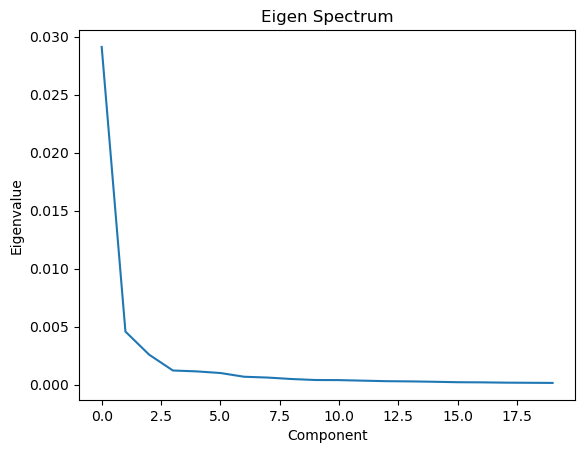

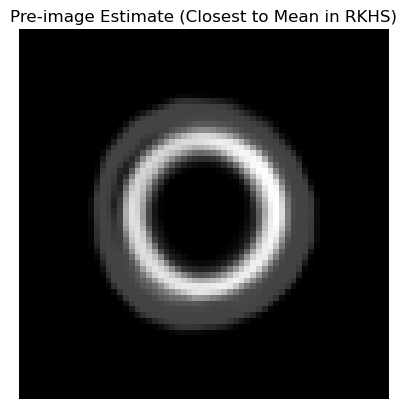

In [107]:
eigvals, pre_img = kernel_pca_analysis(images, gamma=1e-6)
n_components = 20


plt.plot(range(n_components), eigvals[:n_components])
plt.title("Eigen Spectrum")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.show()

plt.imshow(pre_img, cmap='gray')
plt.title("Pre-image Estimate (Closest to Mean in RKHS)")
plt.axis('off')
plt.show()

In [ ]:
distorted_folder_path = 'data/anatomicalSegmentationsDistorted/anatomicalSegmentationsDistorted'

distorted_data = load_data(distorted_folder_path)

distorted_centered = center_image(distorted_data)

In [10]:
def pca_reconstruct(images, n_components=3):
	num_images = images.shape[0]
	X = images.reshape(num_images, -1)
	C = (X.T @ X) / num_images
	eigvals, eigvecs = np.linalg.eigh(C)
	eigvecs = eigvecs[:, ::-1]
	top_components = eigvecs[:, :n_components]
	projections = X @ top_components
	print(projections.shape)
	X_reconstructed = projections @ top_components.T
	return X_reconstructed.reshape(images.shape)

projections = pca_reconstruct(distorted_centered)

(150, 3)


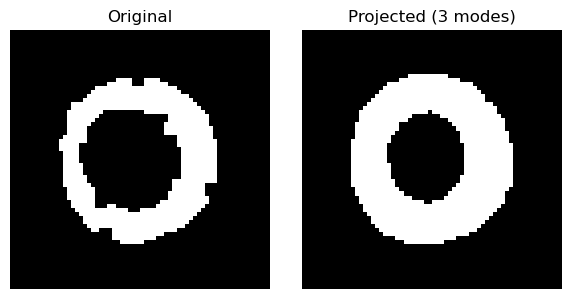

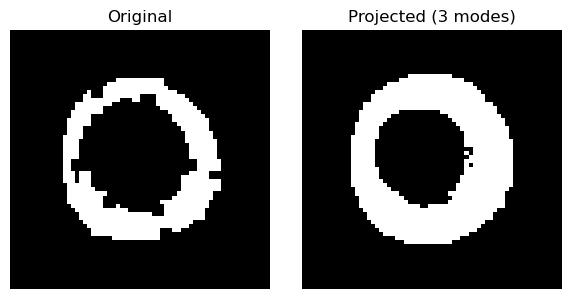

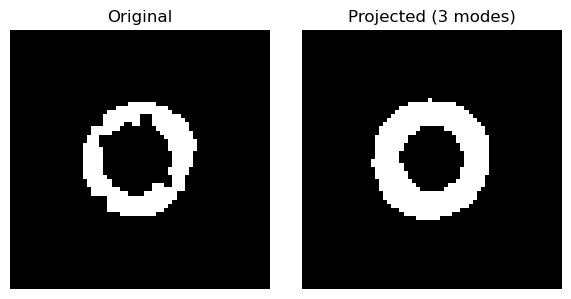

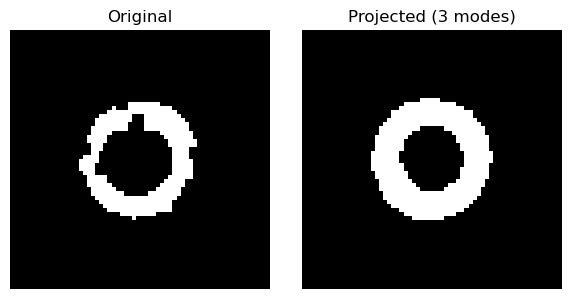

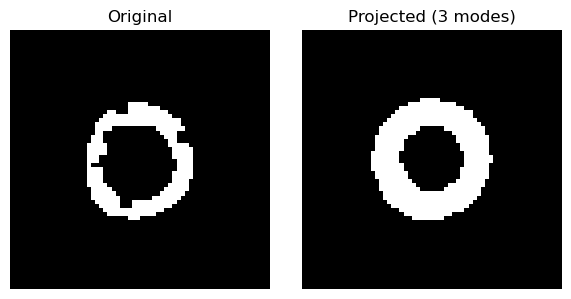

In [11]:
threshold = 0.0
binary_projections = (projections > threshold).astype(np.uint8)

for i in range(5):  # Display 5 sample images
	plt.figure(figsize=(6, 3))

	plt.subplot(1, 2, 1)
	plt.imshow(distorted_centered[i].reshape((64, 64)), cmap='gray')
	plt.title("Original")
	plt.axis('off')

	plt.subplot(1, 2, 2)
	plt.imshow(binary_projections[i].reshape((64, 64)), cmap='gray')
	plt.title("Projected (3 modes)")
	plt.axis('off')

	plt.tight_layout()
	plt.show()

In [299]:
def pre_image_approximation(X, x_i, alpha_j, gamma=1e-3, n_iter=1000, lr=1):
	n_samples, n_features = X.shape
	z = x_i.copy()
	prev_z = np.zeros_like(z)
	k_x = rbf_kernel(X, x_i.reshape(1, -1), gamma=gamma).reshape(-1)  # shape: (n_samples,)
	for _ in range(n_iter):
		diff = z - X  # shape: (n_samples, n_features)
		sq_dist = np.sum(diff**2, axis=1)  # shape: (n_samples,)
		K_zx = rbf_kernel(X, z.reshape(1, -1), gamma=gamma).reshape(-1)

		# Compute gradient vectorized
		weighted_diff = (alpha_j * K_zx)[:, np.newaxis] * diff  # shape: (n_samples, n_features)
		grad = -2 * np.sum(weighted_diff, axis=0)  # shape: (n_features,)

		# Gradient ascent
		z += lr * grad


	return z


In [300]:
def kernel_pca_project(images, gamma=1e-3, n_components=3):
    num_images = images.shape[0]
    X = images.reshape(num_images, -1)
    K = rbf_kernel(X, gamma=gamma)

    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

    eigvals, eigvecs = eigh(K_centered)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    alphas = eigvecs[:, :n_components]
    lambdas = eigvals[:n_components]

    reconstructed_images = np.zeros((num_images, 64, 64))

    for i in range(num_images):
        if i == 5:
            break
        for j in range(n_components):
            reconstructed_images[i] += pre_image_approximation(X, X[i], alphas[:, j], gamma).reshape((64, 64))

    return reconstructed_images

reconstructed_images = kernel_pca_project(distorted_centered)


(150, 64, 64)


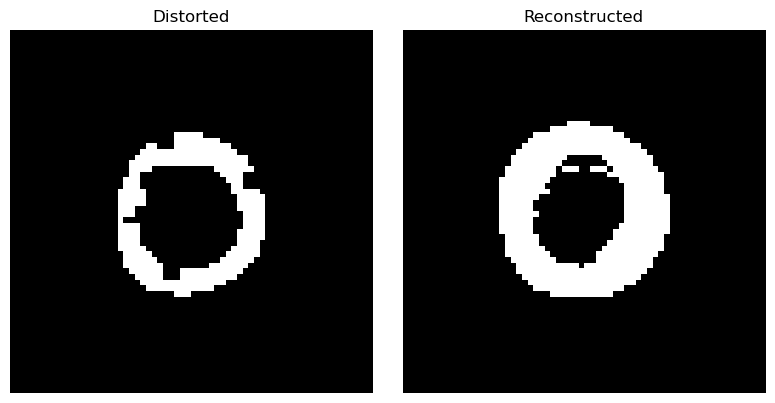

In [308]:
threshold_prime = 0.0
binary_images = (reconstructed_images > threshold_prime).astype(np.uint8) 
print(binary_images.shape)
# idx = np.random.randint(0, binary_images.shape[0])
idx=4
binary_image = (reconstructed_images[idx] > threshold_prime).astype(np.uint8)
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(distorted_centered[idx].reshape((64, 64)), cmap='gray')
plt.title('Distorted')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_images[idx], cmap='gray')
plt.title('Reconstructed')
plt.axis('off')


plt.tight_layout()
plt.show()